In [2]:
import Pkg
Pkg.activate("BosonStars")
# Pkg.resolve()

using Skylight
using CairoMakie
using Printf

  Activating project at `~/BosonStars/BosonStars`


In [3]:
function get_filenames(model)
    filenames = Matrix{String}(undef, 3, 3)
    inclinations = [5, 45, 85]
    Nres = 1200
    for i in 1:3
        modelname = model*string(i)
        for j in 1:3
            ξ = inclinations[j]
            ξstr = string(@sprintf("%02d", ξ))
            Nstr = string(@sprintf("%03d", Nres))
            filenames[i,j] = "$(modelname)_i$(ξstr)deg_N$(Nstr)"
            @assert isfile("io/$(filenames[i,j]).h5") "File $(filenames[i,j]).h5 does not exist"
        end
    end
    return filenames
end

include("ranges.jl")

ranges (generic function with 2 methods)

In [9]:
num_bins = 3
qmin, qmax, zmin, zmaxLBS, Fmax = ranges(get_filenames("LBS"), num_bins)
qmin, qmax, zmin, zmaxSBS, Fmax = ranges(get_filenames("SBS"), num_bins)
zmaxglobal = max(zmaxLBS, zmaxSBS)

4.57064043721602e22

In [26]:
filenames = get_filenames("SBS")
data = Matrix{Any}(undef, 3, 3)
zmaxcols = zeros(3)
num_bins = 50
for j in 1:3
    qmin, qmax, zmin, zmaxcol, Fmax = ranges(filenames[:,j], num_bins) 
    zmaxcols[j] = zmaxcol
    for i in 1:3
        initial_data, output_data, configurations = load_everything(filenames[i,j])
        Iobs, q = observed_bolometric_intensities(initial_data, output_data, configurations)
        xs,ys = axes_ranges(configurations.camera)
        zs = grid_view(Iobs, configurations)
        data[i,j] = (xs, ys, zs)
    end
end

AssertionError: AssertionError: File SCHW1_i05deg_N1200.h5 does not exist

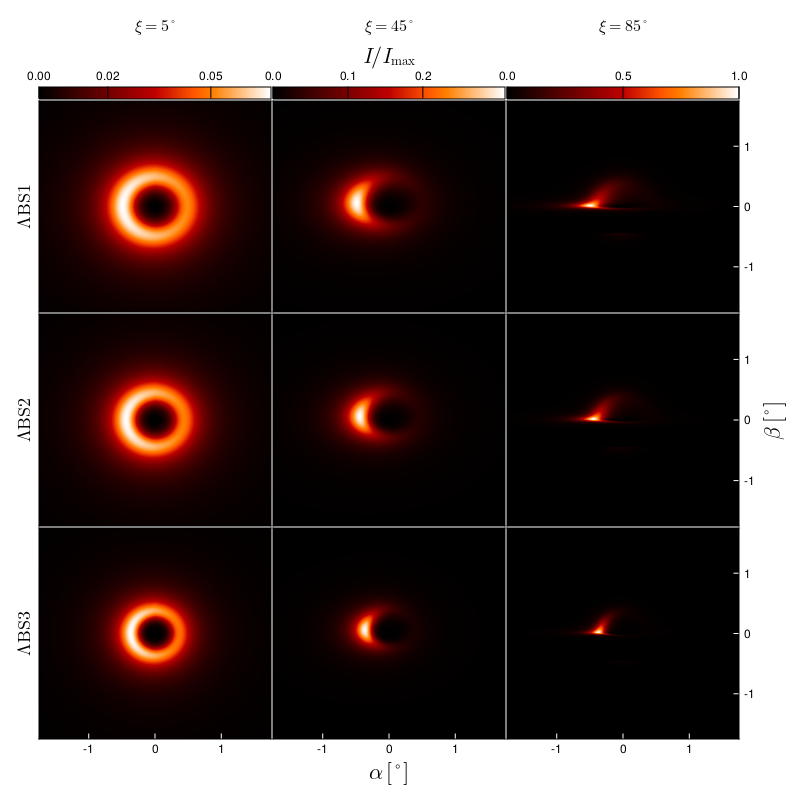

CairoMakie.Screen{IMAGE}


In [25]:
axes = Matrix{Axis}(undef, 3, 3)
set_theme!(; fonts = (; regular = "Times New Roman"))
layout = GridLayout(3, 3)
fig = Figure(layout = layout, resolution = (800, 800))
inclination_labels = [L"\xi = 5^\circ", L"\xi = 45^\circ", L"\xi = 85^\circ"]
# inclination_labels = [L"5^\circ", L"45^\circ", L"85^\circ"]
cbar_ticks_LBS = [[0.0,0.02,0.05],[0.0, 0.1, 0.2],[0.0, 0.5, 1.0]]
cbar_ticks_SBS = [[0.0,0.002,0.004],[0.0, 0.005, 0.01, 0.015],[0.01, 0.02, 0.03]]
for j in 1:3
    for i in 1:3
        ax = Axis(fig[i,j])
        axes[i,j] = ax
        xs, ys, zs = data[i,j]
        xs = rad2deg.(xs)
        ys = rad2deg.(ys)
        hmap = heatmap!(xs, ys, zs/zmaxcols[j]; colormap=:gist_heat, interpolate=true)
    end
end

for k in 1:3

    axbottom = axes[3,k]
    axtop = axes[1,k]
    axright = axes[k,3]
    axleft = axes[k,1]
    # axbottom.xlabel = L"\alpha \, [\text{rad}]"
    axbottom.xlabel = L"\alpha \, [^\circ]"
    axbottom.xlabelvisible = k == 2 #Only show xlabel for middle column
    axbottom.xlabelsize = 22
    axbottom.xticklabelsize = 12
    axbottom.xtickalign = 1
    axbottom.xtickcolor = :white

    axright.yaxisposition = :right
    axright.ylabelvisible = k == 2 #Only show ylabel for middle row
    # axright.ylabel = L"\beta \, [\text{rad}]"
    axright.ylabel = L"\beta \, [^\circ]"
    axright.ylabelsize = 22
    axright.yticklabelsize = 12
    axright.ytickalign = 1
    axright.ytickcolor = :white

    for l in 1:2
    
        #Link axes and hide decorations of non-right and non-bottom axes
        #axis linking is redundant here (the ranges coincide already), but just in case
        linkxaxes!(axright, axes[l,k])
        hidexdecorations!(axes[l,k])
        linkyaxes!(axleft, axes[k,l])
        hideydecorations!(axes[k,l])
    end

    #Make left ylabel visible again to use as model label
    axleft.ylabelvisible = true
    axleft.ylabel = L"\Lambda \text{BS%$(k)}"
    # axleft.ylabel = L"\text{SBS%$(k)}"
    axleft.ylabelsize = 18
    
    
    cbar = Colorbar(fig[0,k], vertical=false, colormap=:gist_heat, colorrange = (0,zmaxcols[k]/zmaxglobal), label=inclination_labels[k])
    cbar.size = 12 
    # cbar.ticks = cbar_ticks_SBS[k]
    cbar.ticks = cbar_ticks_LBS[k]
    cbar.tickalign = 1
    cbar.ticksize = 12
    cbar.ticklabelsize = 12
    cbar.tickcolor = :black
    cbar.label = L"I/I_{\text{max}}"
    cbar.labelsize = 22
    cbar.labelpadding = 0.5
    cbar.labelvisible = k == 2 #Only show colorbar label for middle column
    
    supertitle = Label(fig[-1,k], inclination_labels[k], justification=:center, fontsize=16, color=:black)
    supertitle.tellwidth = false
    supertitle.padding = (0.0, 0.0, 10.0, 0.0)

end

colgap!(fig.layout, 2)
rowgap!(fig.layout, 2)
display(fig)
# save("plots/SBSmosaic.png", fig)
save("plots/LBSmosaic.png", fig)

### Schwarzschild

In [33]:
function get_filenames_schw(model)
    filenames = Matrix{String}(undef, 3, 3)
    inclinations = [5, 45, 85]
    Nres = 1200
    for i in 1:3
        modelname = model
        ξ = inclinations[i]
        ξstr = string(@sprintf("%02d", ξ))
        Nstr = string(@sprintf("%03d", Nres))
        filenames[i] = "$(modelname)_i$(ξstr)deg_N$(Nstr)"
        @assert isfile("io/$(filenames[i]).h5") "File $(filenames[i]).h5 does not exist"
    end
    return filenames
end

get_filenames_schw (generic function with 1 method)

In [56]:
filenames = get_filenames_schw("SCHW")
for j in 1:3
end

In [57]:
filenames = get_filenames_schw("SCHW")
data = Vector{Any}(undef, 3)
zmaxcols = zeros(3)
num_bins = 3
for i in 1:3
    qmin, qmax, zmin, zmaxcol, Fmax = ranges(filenames[i], num_bins) 
    zmaxcols[i] = zmaxcol
    initial_data, output_data, configurations = load_everything(filenames[i])
    Iobs, q = observed_bolometric_intensities(initial_data, output_data, configurations)
    xs,ys = axes_ranges(configurations.camera)
    zs = grid_view(Iobs, configurations)
    data[i] = (xs, ys, zs)
end

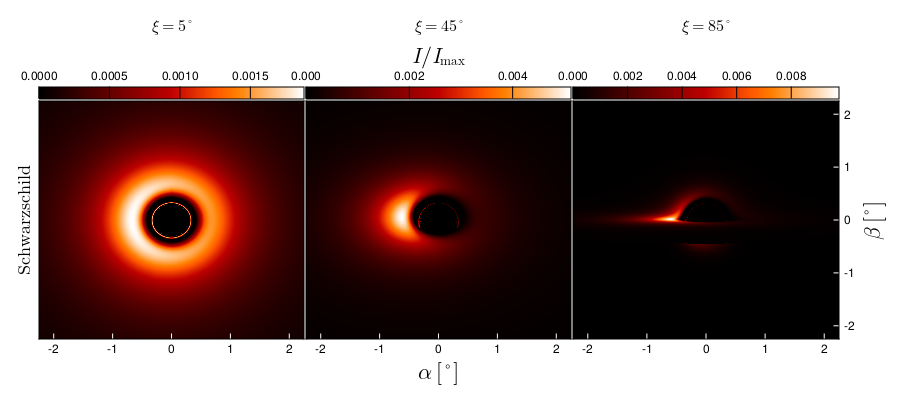

CairoMakie.Screen{IMAGE}


In [59]:
axes = Matrix{Axis}(undef, 1,3)
set_theme!(; fonts = (; regular = "Times New Roman"))
layout = GridLayout(1,3)
fig = Figure(layout = layout, resolution = (900,400))
inclination_labels = [L"\xi = 5^\circ", L"\xi = 45^\circ", L"\xi = 85^\circ"]
# inclination_labels = [L"5^\circ", L"45^\circ", L"85^\circ"]
cbar_ticks_SCHW = [[0.0,0.002,0.004],[0.0, 0.005, 0.01, 0.015],[0.01, 0.02, 0.03]]

for i in 1:3
    ax = Axis(fig[1,i])
    axes[i] = ax
    xs, ys, zs = data[i]
    xs = rad2deg.(xs)
    ys = rad2deg.(ys)
    hmap = heatmap!(xs, ys, zs/zmaxcols[i]; colormap=:gist_heat, interpolate=true)
end

axleft = axes[1,1]
axmid = axes[1,2]
axright = axes[1,3]

#Link axes and hide decorations of non-right and non-bottom axes
#axis linking is redundant here (the ranges coincide already), but just in case
linkyaxes!(axleft, axmid)
linkyaxes!(axleft, axright)
hideydecorations!(axmid)
hideydecorations!(axleft)

#Only show xlabel for middle column
axleft.xlabelvisible = false 
axright.xlabelvisible = false 

axright.yaxisposition = :right
axright.ylabel = L"\beta \, [^\circ]"
axright.ylabelsize = 22
axright.yticklabelsize = 12
axright.ytickalign = 1
axright.ytickcolor = :white

#Make left ylabel visible again to use as model label
axleft.ylabelvisible = true
axleft.ylabel = L"\text{Schwarzschild}"
axleft.ylabelsize = 18

for k in 1:3
    ax = axes[1,k]
    ax.xlabel = L"\alpha \, [^\circ]"
    ax.xlabelsize = 22
    ax.xticklabelsize = 12
    ax.xtickalign = 1
    ax.xtickcolor = :white

    cbar = Colorbar(fig[0,k], vertical=false, colormap=:gist_heat, colorrange = (0,zmaxcols[k]/zmaxglobal))
    cbar.size = 12 
    # cbar.ticks = cbar_ticks_SCHW[k]
    cbar.tickalign = 1
    cbar.ticksize = 12
    cbar.ticklabelsize = 12
    cbar.tickcolor = :black
    cbar.label = L"I/I_{\text{max}}"
    cbar.labelsize = 22
    cbar.labelpadding = 0.5
    cbar.labelvisible = k == 2 #Only show colorbar label for middle column

    supertitle = Label(fig[-1,k], inclination_labels[k], justification=:center, fontsize=16, color=:black)
    supertitle.tellwidth = false
    supertitle.padding = (0.0, 0.0, 10.0, 0.0)

    # colsize!(fig.layout, k, Aspect(1, 1.0))
end

colgap!(fig.layout, 2)
rowgap!(fig.layout, 2)
display(fig)
save("plots/SCHWmosaic.png", fig)